## Analyze A/B Test Results

A/B tests are very commonly performed by data analysts and data scientists. The goal of this project is to understand the results of an A/B test run by an e-commerce website. 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
#### Part I - Probability

In [2]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

`1.` Read in the `ab_data.csv` data and take a look at the top few rows here:

In [160]:
# import dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [161]:
# number of rows in dataset
df.shape[0]

294478

In [162]:
# number of unique users
df['user_id'].nunique()

290584

In [163]:
# proportion of unique users converted
df.query('converted == 1').user_id.nunique() / df['user_id'].nunique()

0.12104245244060237

In [164]:
# Number of times new_page and treatment don't line up
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [165]:
# check for missing values
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Thus, these rows must be removed from the analysis 

In [166]:
# remove rows where treatment is not aligned with new_page
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [167]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [177]:
# Unique users
df2['user_id'].nunique()

290584

In [169]:
# duplicate user_id entries
dup_user = df2['user_id'][df2['user_id'].duplicated()]
dup_user

2893    773192
Name: user_id, dtype: int64

In [170]:
# repeated row information
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [171]:
# drop duplicate row
df2 = df2.drop(dup_user.index)

# confirm drop of duplicate row
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


`3.` What is the probability of an individual converting regardless of the page they receive?

In [179]:
# Conversion probability regardless of landing page
df['user_id'][df['converted'] == 1].count() / df['user_id'].count()

0.11965919355605512

a. Given that an individual was in the `control` group, what is the probability they converted?

In [248]:
# Conversion rate GIVEN an individual was in "control" group
converted = df.query('group == "control" and converted == 1')['user_id'].count()
total = df.query('group == "control"')['user_id'].count()
old_conv_rate = converted / total
old_conv_rate

0.12039917935897611

b. Given that an individual was in the `treatment` group, what is the probability they converted?

In [246]:
# Conversion rate GIVEN an individual was in "treatment" group
converted = df.query('group == "treatment" and converted == 1')['user_id'].count()
total = df.query('group == "treatment"')['user_id'].count()
new_conv_rate = converted / total
new_conv_rate

0.11891957956489856

c. What is the probability that an individual received the new page?

In [247]:
# Probability of receiving new page
new_page = df.query('landing_page == "new_page"')['user_id'].count()
total = df.shape[0]

new_page_prob = new_page / total
new_page_prob 

0.5

#### Observations 

The probability of conversion in the treatment group is **lower** than the conversion rate of users in control group. Without further analysis, we're unable to say with sufficient evidence where the difference in control vs treatment conversion rates is significant. 

<a id='ab_test'></a>
### Part II - A/B Test
 
`1.` Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Based on that assumption, the null and alternative hypotheses are given below:

$$H_{0}: p_{new} - p_{old} \leq 0$$ 
$$H_{1}: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. **Convert rate** for $p_{new}$ under the null

In [259]:
p_new = df2[df2['converted'] == 1]['user_id'].count() / df2['user_id'].count()
p_new

0.11959708724499628

b. **Convert rate** for $p_{old}$ under the null <br><br>

In [258]:
p_old = df2[df2['converted'] == 1]['user_id'].count() / df2['user_id'].count()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [221]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [222]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  

In [260]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.11957883146376712

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null

In [261]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted.mean()

0.11856904883186255

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [231]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_new - p_old

-0.0015093080425366417

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [262]:
# Create sampling distribution with bootstrapping
p_diffs = []
for _ in range(10000):
    p_new = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new]).mean()
    p_old = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old]).mean()
    p_diffs.append(p_new - p_old)

[-0.0006422082878957958,
 -0.0017092190321660594,
 -0.001323846290066752,
 -0.0009590389119699949,
 -0.0008627852584700557,
 -0.0014134466245743077,
 -0.0014134039902767292,
 -0.0006426755597971207,
 0.0018557440175835521,
 0.0016079227834357862,
 0.0033492275352640655,
 0.0038379608787818265,
 0.0023237943264374367,
 0.0015873164905075426,
 0.0015736039740099489,
 0.00014877001278441881,
 -0.0009455668529106814,
 -0.0017094816594390855,
 -0.0013172458376033425,
 0.001484140069254597,
 0.0009816737447764234,
 -0.002328649330758492,
 -0.004462421835001257,
 -0.004834233838702323,
 -0.0038362836455155674,
 -0.002156876219579551,
 -0.002913962053809588,
 -0.0015578867928408152,
 -0.0017713482886370785,
 -0.0025352767381406904,
 -0.0029207023467689996,
 -0.00035324950425526247,
 0.0006102949055386275,
 -0.0005803570070449099,
 -0.0012409214443862976,
 -0.002458942112692236,
 -0.004420112695011372,
 -0.0036424222732249906,
 -0.004709051014189072,
 -0.004309957228732647,
 -0.0034361478778266

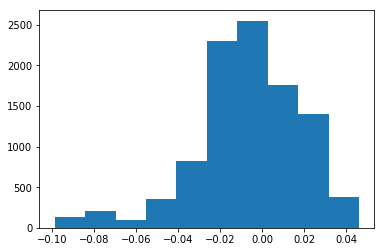

In [263]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [264]:
obs_diff = new_conv_rate - old_conv_rate

# Compute p-value
(p_diffs > obs_diff).mean()

0.4356

### A/B Test Interpretation
The value calculated in the cell above is the p-value. 

The p-value here means:
Given that the null hypothesis is true that the conversion rate of old page is higher than new page, the probability that an effect equal to or greater than the observed difference (new_page_rate - old_page_rate) exists is 0.4356

Since the p-value is lower than the significance value (0.05), we **failed to reject the null hypothesis**. Hence, we're unable to say with sufficient evidence that the new page has a higher conversion rate than the old page.  

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [265]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1')['user_id'].count()
convert_new = df.query('group == "treatment" and converted == 1')['user_id'].count()
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df.query('group == "treatment"')['user_id'].count()

/Users/Devansh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [267]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])

(1.222159202933665, 0.22164742838801588)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [ ]:
### Create the necessary dummy variables

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
### Fit Your Linear Model And Obtain the Results